# KHDLUD Team 10

Thành viên:<br>
Trần Quốc Long - 18120202
<br>Nguyễn Huy Danh - 1712318
<br>Trần Đức Anh - 18120280
<br>Du Chí Nhân - 18120492

## Library

In [27]:
import cpuinfo

import numpy as np
import pandas as pd
import gc, os

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from multiprocessing import cpu_count
from tqdm import tqdm

from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
# Đường dẫn
test_original_data  = '../input/test.csv'
train_original_data = '../input/train.csv'
sample_submission_file = '../input/sample_submission.csv'
SUBMIT_FILE_PATH = f'../output/2nd-place-solution.csv.gz'

## 1. Giới thiệu

### Link cuộc thi

kaggle competion:
https://www.kaggle.com/c/santander-customer-transaction-prediction#
    
solution git:
https://github.com/KazukiOnodera/Santander-Customer-Transaction-Prediction/blob/master/final_solution/akiyama/py/lgb_train_and_predict.py

golf src:
https://github.com/KazukiOnodera/santander-customer-transaction-prediction/blob/master/py/990_2nd_place_solution_golf.py

### Giới thiệu chủ đề: 

Tại Santander, sứ mệnh của chúng tôi là giúp mọi người và doanh nghiệp phát triển thịnh vượng. Chúng tôi luôn tìm cách giúp khách hàng hiểu được sức khỏe tài chính của họ và xác định những sản phẩm và dịch vụ nào có thể giúp họ đạt được các mục tiêu về tiền tệ của mình.

Nhóm khoa học dữ liệu của chúng tôi liên tục thử thách các thuật toán học máy và làm việc với cộng đồng khoa học dữ liệu toàn cầu để đảm bảo chúng tôi có thể xác định chính xác hơn các cách mới để giải quyết thách thức phổ biến nhất, các vấn đề phân loại nhị phân, chẳng hạn như:

Khách hàng có hài lòng không? 
Một khách hàng sẽ mua sản phẩm này? 
Khách hàng có thể trả khoản vay này không?

Trong thử thách này, chúng tôi mời Kagglers giúp chúng tôi xác định khách hàng nào sẽ thực hiện một giao dịch cụ thể trong tương lai, bất kể số tiền đã giao dịch. Dữ liệu được cung cấp cho cuộc thi này có cấu trúc giống với dữ liệu thực mà chúng tôi có sẵn để giải quyết vấn đề này.

### Tập dữ liệu huấn luyện

In [3]:
train = pd.read_csv(train_original_data)
train

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


### Tập dữ liệu kiểm tra

In [4]:
test = pd.read_csv(test_original_data)
test

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,test_199995,13.1678,1.0136,10.4333,6.7997,8.5974,-4.1641,4.8579,14.7625,-2.7239,...,2.0544,9.6849,4.6734,-1.3660,12.8721,1.2013,-4.6195,9.1568,18.2102,4.8801
199996,test_199996,9.7171,-9.1462,7.3443,9.1421,12.8936,3.0191,5.6888,18.8862,5.0915,...,5.0071,6.6548,1.8197,2.4104,18.9037,-0.9337,2.9995,9.1112,18.1740,-20.7689
199997,test_199997,11.6360,2.2769,11.2074,7.7649,12.6796,11.3224,5.3883,18.3794,1.6603,...,5.1536,2.6498,2.4937,-0.0637,20.0609,-1.1742,-4.1524,9.1933,11.7905,-22.2762
199998,test_199998,13.5745,-0.5134,13.6584,7.4855,11.2241,-11.3037,4.1959,16.8280,5.3208,...,3.4259,8.5012,2.2713,5.7621,17.0056,1.1763,-2.3761,8.1079,8.7735,-0.2122


### Cách tính điểm

Kết quả sẽ được đánh giá dựa trên đối tượng đó có khả năng sẽ thanh toán trong tương lại hay không. Điểm số sẽ được đánh giá bằng độ đo khu vực dưới đường cong ROC giữa xác suất xảy ra và kết quả mục tiêu do sự bất cân đối giữa 2 giá trị 0 và 1 ( Không và có)

In [5]:
target = train['target'].value_counts()
target

0    179902
1     20098
Name: target, dtype: int64

<AxesSubplot:>

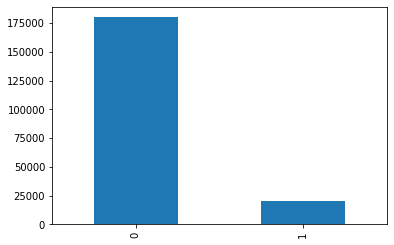

In [31]:
target.plot(kind='bar')

## 2. Các bước thực hiện

### 1. Loại bỏ những giá trị giả

Link: https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split

Input: Dữ liệu của tập test

Output: Dữ liệu của tập test đã được loại bỏ dữ liệu giả (Fake Samples)

Mục đích: Sau khi kiểm tra tập test và tập train thì một điều bất cập đã được nhận ra là: Trong trong tập test có các giá trị độc nhất ở trên từng tính trạng khác với tập train. Tác giả đã đoán rằng người ta đã sử dụng kĩ thuật sampling distributions (phân phối mẫu) từ dữ liệu mẫu thật trong thống kê để tạo ra một số mẫu tổng hợp trong dữ liệu test. Và chúng ta sẽ lọc đi những mẫu dữ liệu giả ấy vì những mẫu giả ấy sẽ không đóng vai trò tính điểm trong tập test chính thức.

Quy trình thực hiện: Dựa trên kiến thức về phân phối mẫu, tác giả đã nghĩ ra một cách để phân loại các dữ liệu giả đấy khi kiểm tra đó chính là<br>
+Nếu 1 mẫu có ít nhất 1 tính trạng mang giá trị độc nhất thì đó sẽ là mẫu thật<br>
+Nếu 1 mẫu sau khi kiểm tra toàn bộ đều không có giá trị độc nhất thì đó chính là mẫu giả.


In [6]:
%%time

te_ = pd.read_csv(test_original_data).drop(['ID_code'], axis=1).values

unique_samples = []
unique_count = np.zeros_like(te_)
for feature in tqdm(range(te_.shape[1])):
    _, index_, count_ = np.unique(te_[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 26.10it/s]

Wall time: 15.2 s


In [7]:
%%time

real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

Wall time: 72.8 ms


### 2. Ghép tập train và tập test sau đó nghịch đảo một số tính trạng

Link: https://www.kaggle.com/sibmike/are-vars-mixed-up-time-intervals

Input: Dữ liệu của tập test và tập train

Output: Dữ liệu dùng để xử sau khi kết hợp và nghịch đảo

Mục đích: Sau khi kiểm tra xác suất xảy ra bằng phân phối bayes chúng ta thấy được có 2 loại biểu đồ là biểu đồ có xác suất P lệch về bên trái và lệch về bên phải. Chúng ta sẽ nghịch đảo 1 loại biểu đồ lại để cho các điểm tương đồng trở nên rõ ràng hơn.

Quy trình thực hiện: Chúng ta sẽ tìm ở trên tập biểu đồ những biểu đồ có xác suất lệch về bên phải và nghịch đảo chúng để xác suất của chúng đồng nhất về bên trái.

Before:

![](https://drive.google.com/file/d/10WaUKsy0znLjyNuNwD5CyQu9ZKiJkZKo/view?usp=sharing) 

After:

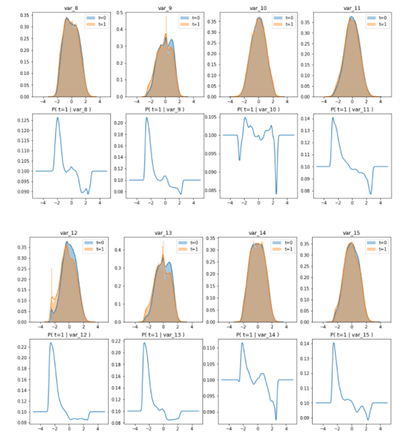

In [8]:
%%time

train = pd.read_csv(train_original_data)
test  = pd.read_csv(test_original_data).drop(synthetic_samples_indexes)

X_train = train.iloc[:, 2:].values
y_train = train.target.values

X_test = test.iloc[:, 1:].values

X = np.concatenate([X_train, X_test], axis=0)
del X_train, X_test; gc.collect()

reverse_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 15, 16, 18, 19, 22, 24, 25, 26,
                27, 29, 32, 35, 37, 40, 41, 47, 48, 49, 51, 52, 53, 55, 60, 61,
                62, 65, 66, 67, 69, 70, 71, 74, 78, 79, 82, 84, 89, 90, 91, 94,
                95, 96, 97, 99, 103, 105, 106, 110, 111, 112, 118, 119, 125, 128,
                130, 133, 134, 135, 137, 138, 140, 144, 145, 147, 151, 155, 157,
                159, 161, 162, 163, 164, 167, 168, 170, 171, 173, 175, 176, 179,
                180, 181, 184, 185, 187, 189, 190, 191, 195, 196, 199,
                
                ]

for j in reverse_list:
    X[:, j] *= -1

Wall time: 15.2 s


### 3. Loại bỏ một số tính trạng không cần thiết và Standrad Scaling

Input: Dữ liệu sau khi đã loại bỏ fake và reverse

Output: Dữ liệu đã chuẩn hóa

Mục đích: Sau khi đã loại bỏ các mẫu fake và những giá trị gây nhiễu, chuẩn hóa dữ liệu sẽ giúp dễ dàng nhận ra các điểm dữ liệu bất thường. Ngoài ra, còn giúp tránh được những vấn đề do  sự khác biệt về độ đo, phục vụ cho việc unpivot ở bước 6

Quy trình thực hiện: 

In [9]:
drop_vars = [7,
            10,
            17,
            27,
            29,
            30,
            38,
            41,
            46,
            96,
            100,
            103,
            126,
            158,
            185]

var_len = 200 - len(drop_vars)

In [10]:
%%time

# drop
X = np.delete(X, drop_vars, 1)

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

Wall time: 1.21 s


### 4. Count round Encoding

Input: Output của bước 3

Output: Dữ liệu cũ + các cột đếm số lượng theo từng cột

Mục đích: Feature engineering, giúp cải thiện kết quả

Quy trình thực hiện:<br>
Count encoding - Với mỗi cột, đếm số lượng giá trị và tạo ra cột mới bằng cách ánh xạ: giá trị -> số lượng<br>
Count round encoding - Tương tự như 4 nhưng giá trị được làm tròn lần lượt là 1,2 và 3 chữ số thập phân rồi mới đếm

In [11]:
# count encoding
X_cnt = np.zeros((len(X), var_len * 4))

for j in tqdm(range(var_len)):
    for i in range(1, 4):
        x = np.round(X[:, j], i+1)
        dic = pd.value_counts(x).to_dict()
        X_cnt[:, i+j*4] = pd.Series(x).map(dic)
    x = X[:, j]
    dic = pd.value_counts(x).to_dict()
    X_cnt[:, j*4] = pd.Series(x).map(dic)

100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [01:30<00:00,  2.06it/s]


In [17]:
X

array([[ 5.75796442e-01,  8.00000000e+00,  1.09300000e+03, ...,
         1.00800000e+03,  1.16000000e+02,  1.20000000e+01],
       [-2.71662629e-01,  3.00000000e+00,  9.73000000e+02, ...,
         1.08200000e+03,  1.22000000e+02,  1.10000000e+01],
       [ 6.79857084e-01,  6.00000000e+00,  1.01500000e+03, ...,
         1.01700000e+03,  1.08000000e+02,  1.20000000e+01],
       ...,
       [-8.20334045e-01,  5.00000000e+00,  8.72000000e+02, ...,
         9.80000000e+02,  9.70000000e+01,  6.00000000e+00],
       [ 3.15282831e-01,  3.00000000e+00,  1.12800000e+03, ...,
         4.27000000e+02,  3.40000000e+01,  7.00000000e+00],
       [ 6.86900455e-02,  5.00000000e+00,  1.12400000e+03, ...,
         9.02000000e+02,  1.01000000e+02,  8.00000000e+00]])

In [18]:
X_cnt

array([[   8., 1093.,  122., ..., 1008.,  116.,   12.],
       [   3.,  973.,   87., ..., 1082.,  122.,   11.],
       [   6., 1015.,   94., ..., 1017.,  108.,   12.],
       ...,
       [   5.,  872.,   90., ...,  980.,   97.,    6.],
       [   3., 1128.,  119., ...,  427.,   34.,    7.],
       [   5., 1124.,  108., ...,  902.,  101.,    8.]])

### 5. Unpivot tất cả các cột

Input: Output của bước 4

Output: Họ cho rằng giá trị các cột là độc lập với nhau và có thể dùng giá trị của 1 cột để dự đoán target nên họ unpivot

Mục đích: Hỗ trợ dự đoán target vì họ đã thử và thấy có cải thiện kết quả

Thực hiện: Cứ mỗi biến sẽ là 6 cột (Raw_value, 4 cột đã encode, thuộc về cột nào) đem đi stack vào nhau

In [12]:
# raw + count feature
X_raw = X.copy() # rename for readable
del X; gc.collect()

X = np.zeros((len(X_raw), var_len * 5))
for j in tqdm(range(var_len)):
    X[:, 5*j+1:5*j+5] = X_cnt[:, 4*j:4*j+4]
    X[:, 5*j] = X_raw[:, j]

100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [00:19<00:00,  9.58it/s]


In [19]:
X

array([[ 5.75796442e-01,  8.00000000e+00,  1.09300000e+03, ...,
         1.00800000e+03,  1.16000000e+02,  1.20000000e+01],
       [-2.71662629e-01,  3.00000000e+00,  9.73000000e+02, ...,
         1.08200000e+03,  1.22000000e+02,  1.10000000e+01],
       [ 6.79857084e-01,  6.00000000e+00,  1.01500000e+03, ...,
         1.01700000e+03,  1.08000000e+02,  1.20000000e+01],
       ...,
       [-8.20334045e-01,  5.00000000e+00,  8.72000000e+02, ...,
         9.80000000e+02,  9.70000000e+01,  6.00000000e+00],
       [ 3.15282831e-01,  3.00000000e+00,  1.12800000e+03, ...,
         4.27000000e+02,  3.40000000e+01,  7.00000000e+00],
       [ 6.86900455e-02,  5.00000000e+00,  1.12400000e+03, ...,
         9.02000000e+02,  1.01000000e+02,  8.00000000e+00]])

In [13]:
# treat each var as same
X_train_concat = np.concatenate([
    np.concatenate([
        X[:200000, 5*cnum:5*cnum+5], 
        np.ones((len(y_train), 1)).astype("int")*cnum
    ], axis=1) for cnum in range(var_len)], axis=0)
y_train_concat = np.concatenate([y_train for cnum in range(var_len)], axis=0)

Và đây là kết quả sau khi tiền xử lý

In [14]:
show = pd.DataFrame(X_train_concat, columns = ['raw values', 'count_1', 'count_2', 'count_3', 'count_4','var'])
show

,raw values,count_1,count_2,count_3,count_4,var
0,0.575796,8.0,1093.0,122.0,14.0,0.0
1,-0.271663,3.0,973.0,87.0,6.0,0.0
2,0.679857,6.0,1015.0,94.0,14.0,0.0
3,-0.126794,3.0,1084.0,93.0,6.0,0.0
4,0.275857,8.0,1131.0,135.0,18.0,0.0
...,...,...,...,...,...,...
36999995,1.396420,2.0,527.0,39.0,6.0,184.0
36999996,-0.348698,2.0,1017.0,113.0,13.0,184.0
36999997,-0.718784,1.0,1101.0,116.0,17.0,184.0
36999998,1.016240,1.0,800.0,68.0,6.0,184.0


### 6. Training và Predict (Continue)

Input: dữ liệu sau bước unpivot được gán tên các cột vào

Output: các model sau khi được train

Mục đích: từ data sau khi đã chuẩn hóa, tạo ra các model, dùng các model này để dự đoán

Mô tả: Trong solution, tác giả train và predict sử dụng 2 phương pháp, là Neural Network với thư viện keras và Gradient Boosting với framework LightBGM

#### Light GBM

##### train and predict

In [15]:
class ModelExtractionCallback(object):
    """
    original author : momijiame
    ref : https://blog.amedama.jp/entry/lightgbm-cv-model
    description : Class for callback to extract trained models from lightgbm.cv(). 
    note: This class depends on private class '_CVBooster', so there are some future risks. 
    """

    def __init__(self):
        self._model = None

    def __call__(self, env):
        # _CVBooster の参照を保持する
        self._model = env.model

    def _assert_called_cb(self):
        if self._model is None:
            # コールバックが呼ばれていないときは例外にする
            raise RuntimeError('callback has not called yet')

    @property
    def boosters_proxy(self):
        self._assert_called_cb()
        # Booster へのプロキシオブジェクトを返す
        return self._model

    @property
    def raw_boosters(self):
        self._assert_called_cb()
        # Booster のリストを返す
        return self._model.boosters

    @property
    def best_iteration(self):
        self._assert_called_cb()
        # Early stop したときの boosting round を返す
        return self._model.best_iteration

In [16]:
model_output_dir = f'../processed/lgb_output/'
if not os.path.isdir(model_output_dir):
    os.makedirs(model_output_dir)

dataset_dir = '../processed/dataset/'
X_train = pd.read_pickle(os.path.join(dataset_dir, 'X_train.pickle'))
y_train = pd.read_pickle(os.path.join(dataset_dir, 'y_train.pickle'))
X_test = pd.read_pickle(os.path.join(dataset_dir, 'X_test.pickle'))

params = {
    'bagging_freq': 5,
    'bagging_fraction': 0.95,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 1.0,
    'learning_rate': 0.005,
    'max_depth': -1,
    'metric':'binary_logloss',
    'min_data_in_leaf': 30,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 64,
    'num_threads': cpu_count(),
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': 1}

train_dset = lgb.Dataset(
    concat_X_train, 
    pd.concat([y_train for c in range(200)], axis=0), 
    free_raw_data=False
    )

FileNotFoundError: [Errno 2] No such file or directory: '../processed/dataset/X_train.pickle'

In [ ]:
print('CPU train: ' + cpuinfo.get_cpu_info()['brand_raw'] + ' ' + cpuinfo.get_cpu_info()['hz_advertised_friendly'])
for fold_set_number in range(10):
    print('### start iter {} in 10 ###'.format(fold_set_number+1))
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019+fold_set_number)
    folds = [
        [
            np.concatenate([_trn+i * X_train.shape[0] for i in range(200)]), 
            np.concatenate([_val+i * X_train.shape[0] for i in range(200)])
        ] for _trn, _val in skf.split(X_train, y_train)]

    extraction_cb = ModelExtractionCallback()
    callbacks = [extraction_cb,]

    print('start training. ')
    cv_result = lgb.cv(params, train_set=train_dset, num_boost_round=100000, 
                             early_stopping_rounds=100, verbose_eval=100, folds=folds, callbacks=callbacks)
    bsts = extraction_cb.raw_boosters
    best_iteration = extraction_cb.best_iteration
    print('training end. ')

    print('start predicting. ')
    oof_pred_array = np.ones((X_train.shape[0], 200))
    test_pred_array = np.ones((X_test.shape[0], 5, 200))
    for cnum in tqdm(range(200)):
        for i, bst in enumerate(bsts):
            cv_valid_index = bst.valid_sets[0].used_indices
            cv_valid_index = cv_valid_index[:int(cv_valid_index.shape[0]/200)]
            # oofの予測
            cv_valid_data = arrange_dataset(X_train, cnum).iloc[cv_valid_index].values
            oof_pred_array[cv_valid_index, cnum] = bst.predict(cv_valid_data, num_iteration=best_iteration)
            # testの予測
            test_pred_array[:, i, cnum] = bst.predict(arrange_dataset(X_test, cnum).values, num_iteration=best_iteration)
    print('prediction end. ')

    print('start postprocess. ')
    thr = 0.500
    oof_pred_odds_prod = np.ones((X_train.shape[0]))
    test_pred_odds_prod = np.ones((X_test.shape[0], 5))
    for cnum in tqdm(range(200)):
        tmp_auc = roc_auc_score(y_train, oof_pred_array[:, cnum])
        if tmp_auc >= thr:
            oof_pred_odds_prod *= oof_pred_array[:, cnum] / (1 - oof_pred_array[:, cnum])
            test_pred_odds_prod *= test_pred_array[:,:, cnum] / (1 - test_pred_array[:,:, cnum])
    print('postprocess end. auc : {0:.6f}'.format(roc_auc_score(y_train, oof_pred_odds_prod)))

    print('save iteration results')
    pd.DataFrame(oof_pred_odds_prod, index=X_train.index, columns=['pred'])\
        .to_pickle(os.path.join(model_output_dir, f'oof_preds_{fold_set_number}.pkl.gz'), compression='gzip')
    for fold_num in range(5):
        model_management_num = fold_num + fold_set_number*5
        pd.DataFrame(test_pred_odds_prod[:, fold_num], index=X_test.index, columns=['pred'])\
            .to_pickle(os.path.join(model_output_dir, f'test_preds_{model_management_num}.pkl.gz'), compression='gzip')

##### postprocess

In [ ]:
rawfile_dir = '../input/'
dataset_dir = '../processed/dataset/'
model_output_dir = f'../processed/lgb_output/'
submitfile_dir = '../output/'
if not os.path.isdir(submitfile_dir):
    os.makedirs(submitfile_dir)

y_train = pd.read_pickle(os.path.join(dataset_dir, 'y_train.pickle'))
real_id = pd.read_pickle(os.path.join(dataset_dir, 'real_id.pickle'))
fake_id = pd.read_pickle(os.path.join(dataset_dir, 'fake_id.pickle'))

oof_pred_list = []
test_pred_list = []
for fold_set_number in range(10):
    _oof_pred = pd.read_pickle(os.path.join(model_output_dir, f'oof_preds_{fold_set_number}.pkl.gz'))\
        .rank(pct=True).reset_index()
    for model_management_num in range(fold_set_number, fold_set_number+5):
        _test_pred = pd.read_pickle(os.path.join(model_output_dir, f'test_preds_{model_management_num}.pkl.gz'))
        _real_test_pred = _test_pred.loc[real_id]
        _fake_test_pred = _test_pred.loc[fake_id]
        _real_test_pred = _real_test_pred.rank(pct=True).reset_index()
        _fake_test_pred = _fake_test_pred.rank(pct=True).reset_index()
        test_pred_list.append(pd.concat([_real_test_pred, _fake_test_pred], axis=0))
    _auc = roc_auc_score(y_train.loc[_oof_pred['ID_code']], _oof_pred[f'pred'])
    print('{0} : {1:.6f}'.format(fold_set_number, _auc))
    oof_pred_list.append(_oof_pred)
oof_pred_concat_rank = pd.concat(oof_pred_list, axis=0)
test_pred_concat_rank = pd.concat(test_pred_list, axis=0)
oof_pred_rank_mean = oof_pred_concat_rank.groupby('ID_code').mean()
test_pred_rank_mean = test_pred_concat_rank.groupby('ID_code').mean()
total_auc = roc_auc_score(y_train.loc[oof_pred_rank_mean.index], oof_pred_rank_mean)
print('total mean auc : {0:.6f}'.format(total_auc))

sub = pd.read_csv(os.path.join(rawfile_dir, 'sample_submission.csv.zip'))
sub = sub[['ID_code']].merge(
    test_pred_rank_mean.reset_index().rename(columns={'pred':'target'}), how='left').fillna(0)
sub.to_csv(os.path.join(submitfile_dir, 'akiyama_lgb.csv.gz'), index=False, compression='gzip')

#### Neural Network

##### train and predict

In [ ]:
print('CPU train: ' + cpuinfo.get_cpu_info()['brand_raw'] + ' ' + cpuinfo.get_cpu_info()['hz_advertised_friendly'])
class RankGaussScalar(object):
    """
    usage: 
    rgs = RankGaussScalar()
    rgs.fit(df_X)
    df_X_converted = rgs.transform(df_X)
    df_X_test_converted = rgs.transform(df_X_test)
    """
    def __init__(self):
        self.fit_done = False

    def rank_gauss(self, x):
        N = x.shape[0]
        temp = x.argsort()
        rank_x = temp.argsort() / N
        rank_x -= rank_x.mean()
        rank_x *= 2
        efi_x = erfinv(rank_x)
        efi_x -= efi_x.mean()
        return efi_x

    def fit(self, df_x):
        """
        df_x: fitting対象のDataFrame
        """
        self.train_unique_rankgauss = {}
        self.target_cols = np.sort(df_x.columns)
        for c in self.target_cols:
            unique_val = np.sort(df_x[c].unique())
            self.train_unique_rankgauss[c]= [unique_val, self.rank_gauss(unique_val)]
        self.fit_done = True

    def transform(self, df_target):
        """
        df_target: transform対象のDataFrame
        """
        assert self.fit_done
        assert np.all(np.sort(np.intersect1d(df_target.columns, self.target_cols)) == np.sort(self.target_cols))
        df_converted_rank_gauss = pd.DataFrame(index=df_target.index)
        for c in self.target_cols:
            df_converted_rank_gauss[c] = np.interp(df_target[c], 
                                                   self.train_unique_rankgauss[c][0], 
                                                   self.train_unique_rankgauss[c][1]) # ,left=0, right=0)
        return df_converted_rank_gauss

In [ ]:
def build_model():
    
    model_input = Input(shape=(6,))
    num_input = Lambda(lambda x: x[:, :5], output_shape=(5,))(model_input)
    cat_input = Lambda(lambda x: x[:, 5:], output_shape=(1,))(model_input)
    
    x = num_input
    x = Dense(256)(num_input)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    emb_dim = 128
    y = Embedding(200, emb_dim, input_length=1)(cat_input)
    y = Flatten()(y)
    
    z = Concatenate()([x, y])
    z = Dense(256)(z)
    z = PReLU()(z)
    z = BatchNormalization()(z)
    z = Dropout(rate=0.5)(z)
    z = Dense(256)(z)
    z = PReLU()(z)
    z = BatchNormalization()(z)
    z = Dropout(rate=0.5)(z)
    z = Dense(256)(z)
    z = PReLU()(z)
    z = BatchNormalization()(z)
    output = Dense(1, activation="sigmoid")(z)
    model = Model(inputs=model_input, outputs=output)
    return model

In [ ]:
model_output_dir = f'../processed/nn_output/'
if not os.path.isdir(model_output_dir):
    os.makedirs(model_output_dir)

dataset_dir = '../processed/dataset/'
X_train = pd.read_pickle(os.path.join(dataset_dir, 'X_train.pickle'))
y_train = pd.read_pickle(os.path.join(dataset_dir, 'y_train.pickle'))
X_test = pd.read_pickle(os.path.join(dataset_dir, 'X_test.pickle'))

epochs = 40
batch_size = 1024
patience = 5

weights_dir = '../processed/keras_weights'
if not os.path.isdir(weights_dir):
    os.makedirs(weights_dir)

for fold_set_number in range(10):
    print('### start iter {} in 10 ###'.format(fold_set_number+1))
    K.clear_session()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019+fold_set_number)
    folds = [
        [
            np.concatenate([_trn+i * X_train.shape[0] for i in range(200)]), 
            np.concatenate([_val+i * X_train.shape[0] for i in range(200)])
        ] for _trn, _val in skf.split(X_train, y_train)]

    for fold_num in range(5):
        print(f'## Start KFold number {fold_num} ##')
        model_management_num = fold_num + fold_set_number*5
        skf_train_index, skf_valid_index = folds[fold_num]

        nonprogress_counter=0
        e_auc_best = 0

        weight_path = os.path.join(weights_dir, f'{model_management_num}.model')
        skf_X_train = train_dset[0].iloc[skf_train_index].copy()
        skf_y_train = train_dset[1].iloc[skf_train_index]
        skf_X_valid = train_dset[0].iloc[skf_valid_index].copy()
        skf_y_valid = train_dset[1].iloc[skf_valid_index]
        single_valid_index = skf_valid_index[:skf_valid_index.shape[0]//200]  

        rgscaler = RankGaussScalar()
        rgscaler.fit(skf_X_train.iloc[:, :5].astype(float))
        skf_X_train.iloc[:, :5] = rgscaler.transform(skf_X_train.iloc[:, :5].astype(float))
        skf_X_valid.iloc[:, :5] = rgscaler.transform(skf_X_valid.iloc[:, :5].astype(float))

        print('start training. ')
        for _e in range(epochs):
            print('epoch {}'.format(_e))
            if _e == 0:
                model = build_model()
                #optimizer = optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-4)
                optimizer = optimizers.adam(lr=0.001)
                model.compile(loss='binary_crossentropy', optimizer=optimizer)

            history = model.fit(skf_X_train.values, skf_y_train,
                            validation_data=[skf_X_valid.values, skf_y_valid], 
                            epochs=1,
                            batch_size=batch_size,
                            shuffle=True,
                            verbose=1)

            oof_pred_array = np.ones((single_valid_index.shape[0], 200))
            for cnum in range(200):
                oof_pred_array[:, cnum] = np.squeeze(
                    model.predict(
                        skf_X_valid.iloc[cnum*single_valid_index.shape[0]:(cnum+1)*single_valid_index.shape[0]].values, batch_size=100000
                    )
                )
            e_auc = roc_auc_score(y_train.iloc[single_valid_index], oof_pred_array.prod(axis=1))

            print('\tauc : {0:.6f}'.format(e_auc))
            if e_auc > e_auc_best:
                model.save_weights(weight_path)
                e_auc_best = e_auc
                nonprogress_counter = 0
            else:
                nonprogress_counter += 1

            if (nonprogress_counter >= patience) or (_e == (epochs-1)):
                print('fold end. ')
                break
        print('training end. ')

        model.load_weights(weight_path)

        print('start predicting. ')
        oof_pred_array = np.ones((single_valid_index.shape[0], 200))
        test_pred_array = np.ones((X_test.shape[0], 200))
        for cnum in range(200):
            tmp_X_test = arrange_dataset(X_test, cnum).copy()
            tmp_X_test.iloc[:, :5] = rgscaler.transform(tmp_X_test.iloc[:, :5].astype(float))
            oof_pred_array[:, cnum] = np.squeeze(
                model.predict(
                    skf_X_valid.iloc[cnum*single_valid_index.shape[0]:(cnum+1)*single_valid_index.shape[0]].values, batch_size=100000
                )
            )
            test_pred_array[:, cnum] = np.squeeze(model.predict(tmp_X_test.values, batch_size=100000))
        fold_oof_pred = pd.DataFrame(oof_pred_array, index=X_train.index[single_valid_index])
        fold_test_pred = pd.DataFrame(test_pred_array, index=X_test.index)
        print('prediction end. ')

        print('save fold results')
        fold_oof_pred.to_pickle(os.path.join(model_output_dir, f'oof_preds_{model_management_num}.pkl.gz'), compression='gzip')
        fold_test_pred.to_pickle(os.path.join(model_output_dir, f'test_preds_{model_management_num}.pkl.gz'), compression='gzip')

##### postprocess

In [ ]:
rawfile_dir = '../input/'
dataset_dir = '../processed/dataset/'
model_output_dir = f'../processed/nn_output/'
submitfile_dir = '../output/'
if not os.path.isdir(submitfile_dir):
    os.makedirs(submitfile_dir)

y_train = pd.read_pickle(os.path.join(dataset_dir, 'y_train.pickle'))
real_id = pd.read_pickle(os.path.join(dataset_dir, 'real_id.pickle'))
fake_id = pd.read_pickle(os.path.join(dataset_dir, 'fake_id.pickle'))

oof_pred_list = []
test_pred_list = []
for model_management_num in range(50):
    _oof_pred = pd.read_pickle(os.path.join(model_output_dir, f'oof_preds_{model_management_num}.pkl.gz'))
    _oof_pred = (_oof_pred / (1 - _oof_pred)).prod(axis=1).rank(pct=True).to_frame(name=f'pred').reset_index()
    _test_pred = pd.read_pickle(os.path.join(model_output_dir, f'test_preds_{model_management_num}.pkl.gz'))
    _test_pred = (_test_pred / (1 - _test_pred)).prod(axis=1)
    _real_test_pred = _test_pred.loc[real_id]
    _fake_test_pred = _test_pred.loc[fake_id]
    _real_test_pred = _real_test_pred.rank(pct=True).to_frame(name=f'pred').reset_index()
    _fake_test_pred = _fake_test_pred.rank(pct=True).to_frame(name=f'pred').reset_index()
    _auc = roc_auc_score(y_train.loc[_oof_pred['ID_code']], _oof_pred[f'pred'])
    print('{0} : {1:.6f}'.format(model_management_num, _auc))
    oof_pred_list.append(_oof_pred)
    test_pred_list.append(pd.concat([_real_test_pred, _fake_test_pred], axis=0))
oof_pred_concat_rank = pd.concat(oof_pred_list, axis=0)
test_pred_concat_rank = pd.concat(test_pred_list, axis=0)
oof_pred_rank_mean = oof_pred_concat_rank.groupby('ID_code').mean()
test_pred_rank_mean = test_pred_concat_rank.groupby('ID_code').mean()
total_auc = roc_auc_score(y_train.loc[oof_pred_rank_mean.index], oof_pred_rank_mean)
print('total mean auc : {0:.6f}'.format(total_auc))

sub = pd.read_csv(os.path.join(rawfile_dir, 'sample_submission.csv.zip'))
sub = sub[['ID_code']].merge(test_pred_rank_mean.reset_index()\
                             .rename(columns={'pred':'target'}), how='left').fillna(0)
sub.to_csv(os.path.join(submitfile_dir, 'akiyama_nn.csv.gz'), index=False, compression='gzip')

### 7. Chuyển dự đoán từ dạng xác suất sang tỉ lệ (Continue)